---
title: Baboon admixture
date: last-modified
author: Kasper Munch

---

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from IPython.display import Markdown

%matplotlib inline
%config InlineBackend.figure_format='svg'

from genominterv.decorators import bootstrap
from genominterv.stats import proximity_stat, jaccard_stat

from scipy.stats import fisher_exact

import geneinfo.plot as gplt
import geneinfo.information as gi
import geneinfo.utils as utils
# utils.clear_cache()
# utils.disable_cache = True
from geneinfo.utils import GeneListCollection
from geneinfo.utils import GeneList as glist

sheet = GeneListCollection(google_sheet='1JSjSLuto3jqdEnnG7JqzeC_1pUZw76n7XueVAYrUOpk')

def fisher(background_set, set_a, set_b):
    M = len(background_set) 
    N = len(background_set.intersection(set_a)) 
    n = len(background_set.intersection(set_b))
    x = len(background_set.intersection(set_b).intersection(set_a))
    table = [[  x,           n - x          ],
             [ N - x,        M - (n + N) + x]]
    return table, fisher_exact(table, alternative='greater').pvalue, glist(sorted(set_a.intersection(set_b)))

# Pure segments in baboon cooridnates

In [9]:
df = pd.read_hdf('../data/mean_window_df_eth.h5')
meta_data_samples = pd.read_csv("../data/Papio_metadata_with_clustering.txt", sep =" ")
gog_olives = meta_data_samples.loc[meta_data_samples.Origin == "Gog Woreda, Gambella region, Ethiopia"].PGDP_ID
chrX_lai_eth = df.loc[df.individual.isin(gog_olives) & (df.chrom == 'all_chrX')].groupby(["chrom", "individual", "start", "end"]).mean().reset_index()
chrX_lai_eth.head()

,chrom,individual,start,end,haplotype,north_sum
0,all_chrX,PD_0720,0,100000,0.5,0.0
1,all_chrX,PD_0720,100000,200000,0.5,0.0
2,all_chrX,PD_0720,200000,300000,0.5,0.0
3,all_chrX,PD_0720,300000,400000,0.5,0.0
4,all_chrX,PD_0720,400000,500000,0.5,0.0


In [10]:
win_means = chrX_lai_eth.groupby(['start', 'end']).north_sum.mean().reset_index()
win_means.head()

,start,end,north_sum
0,0,100000,0.0
1,100000,200000,0.0
2,200000,300000,0.0
3,300000,400000,0.0
4,400000,500000,0.0


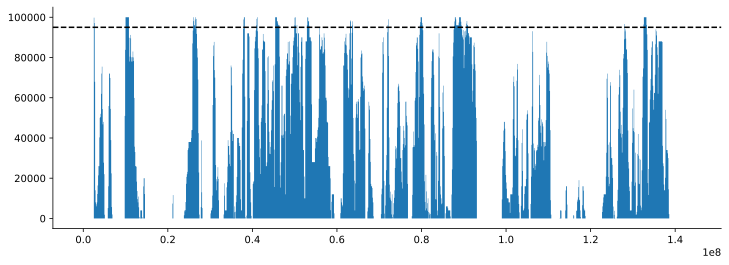

In [22]:
#| label: fig-gog-ancestry-prop

plot_df = utils.stairs(win_means)
plt.figure(figsize=(12, 4))
plt.fill_between(plot_df.pos, plot_df.north_sum)
plt.axhline(y=95000, color='black', linestyle='dashed')
sns.despine()

In [23]:
win_means['pure'] = (win_means.north_sum == 0) | (win_means.north_sum >= 95000)

win_means['segment_id'] = (win_means.pure.shift() != win_means.pure).cumsum()

pure = win_means.groupby('segment_id', as_index=False).agg(dict(
     start='min', 
     end='max', 
     north_sum='mean', 
     pure='mean'
))

pure = pure.loc[pure.pure == 1, :]
pure['species'] = ['hama' if x >= 95000 else 'olive' for x in pure.north_sum]
pure['chrom'] = 'chrX'
pure['start'] = pure.start.astype(int)
pure['end'] = pure.end.astype(int)
pure['north_sum'] = pure.north_sum.astype(int)
olive_pure_segments = pure.loc[pure.species == 'olive', ['chrom', 'start', 'end', 'north_sum']]
hama_pure_segments = pure.loc[pure.species == 'hama', ['chrom', 'start', 'end', 'north_sum']]

In [24]:
hama_pure_segments.head(3)

,chrom,start,end,north_sum
6,chrX,10000000,10800000,100000
16,chrX,26000000,26600000,98169
18,chrX,26700000,26800000,99170


In [25]:
olive_pure_segments.head(3)

,chrom,start,end,north_sum
0,chrX,0,2700000,7292
2,chrX,5100000,5800000,0
4,chrX,6900000,9800000,0


In [27]:
def plot_intervals(query=None, annot=None, **kwargs):

    import matplotlib.pyplot as plt

    vlines = kwargs.get('vlines', [])
    if 'vlines' in kwargs: del kwargs['vlines']
    figsize = kwargs.get('figsize', (8, 1.5*len(kwargs)-1))
    if 'figsize' in kwargs: del kwargs['figsize']
    scale_col = kwargs.get('scale', 1)
    if 'scale' in kwargs: del kwargs['scale']

    tups = list(kwargs.items())
    tups = reversed(tups)

    df_list = []
    labels = []
    for label, df in tups:
        labels.append(label)
        df['label'] = np.repeat(label, df.index.size)
        df_list.append(df)
    bigdf = pd.concat(df_list)

    bigdf['chrom'] = pd.Categorical(bigdf['chrom'], bigdf['chrom'].unique())
    bigdf['label'] = pd.Categorical(bigdf['label'], bigdf['label'].unique())

    gr = bigdf.groupby('chrom', observed=False)

    fig, axes = plt.subplots(gr.ngroups, 1, figsize=figsize, 
                            sharey=True
                            #  sharex=True
                             )
    if type(axes) is not np.ndarray:
        # in case there is only one axis so it not returned as a list
        axes = [axes]
    
    for i, chrom in enumerate(gr.groups):
        _df = gr.get_group(chrom)
        _gr = _df.groupby('label', observed=False)
        for y, label in enumerate(_gr.groups):
            try:
                df = _gr.get_group(label)
            except KeyError:
                continue
            y = np.repeat(y, df.index.size)
            for j in range(len(df.start)):
                # axes[i].hlines(y, df.start.tolist(), df.end.tolist(), alpha=df[alpha_col], lw=10, colors=f'C{y[0]}', capstyle='butt')
                axes[i].hlines(y, df.start.iloc[j], df.end.iloc[j], lw=10*df[scale_col].iloc[j], colors=f'C{y[0]}', capstyle='butt')
            delta = len(labels)/10

        axes[i].spines['top'].set_visible(False)
        axes[i].spines['left'].set_visible(False)
        axes[i].spines['right'].set_visible(False)

        axes[i].set_yticks(list(range(len(labels))), labels)
        axes[i].tick_params(axis='y', which='both', left=False)
        axes[i].set_ylim(-1, len(labels)-0.7)
        # axes[i].set_xlim(df.start.min()-delta, df.end.max()+delta)
        if i != gr.ngroups-1:
            axes[i].tick_params(axis='x', which='both', bottom=False)

        axes[i].set_title(chrom, loc='left', fontsize=10)

    for y, ax in enumerate(axes):
        y = np.repeat(y, len(vlines))
        axes[i].vlines(vlines, *ax.get_ylim(), lw=0.1, colors='black', zorder=0)
    
    plt.tight_layout()
    return axes

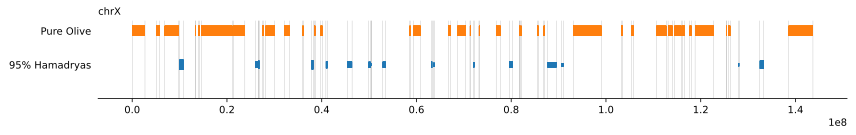

In [28]:
#| label: fig-gog-pure-regions

edges = pd.concat(
    [olive_pure_segments.start, olive_pure_segments.end, hama_pure_segments.start, hama_pure_segments.end, 
    ]).sort_values().unique()

axes = plot_intervals(**{
    'Pure Olive':olive_pure_segments.assign(scale=np.repeat(1, len(olive_pure_segments.north_sum))),
    '95% Hamadryas':hama_pure_segments.assign(scale=(hama_pure_segments.north_sum-95000)/5000),
    'vlines':edges,
    'figsize':(12, 2),
    'scale': 'scale'
    }
)

In [29]:
lst = []
for tup in hama_pure_segments.itertuples():
    lst.extend([x[0] for x in gi.gene_coords_region(tup.chrom, tup.start, tup.end, assembly='papAnu4')])
hama_genes = glist(sorted(set(lst)))
hama_genes

ATP6AP2,GCNA,LOC101001655,LOC101022217,MAGIX,PQBP1,SYTL4
CACNA1F,GLOD5,LOC101001888,LOC101023878,MED14,PRAF2,TBC1D25
CCDC120,GPKOW,LOC101002595,LOC103880652,MED14OS,PRICKLE3,TFE3
CCDC22,GRIPAP1,LOC101002941,LOC103880712,MPC1L,PRPS2,TIMM17B
CXCR3,HDAC6,LOC101003062,LOC103880729,NDP,RBM3,TLR7
CXHXorf38,HSD17B10,LOC101015257,LOC103880750,NHSL2,RIBC1,TLR8
DIAPH2,HUWE1,LOC101015597,LOC103880790,OGT,RTL5,TMSB4X
EBP,IL1RAPL1,LOC101015714,LOC108583794,OTUD5,SLC35A2,TNMD
ERAS,IQSEC2,LOC101017377,LOC108583817,PCDH19,SLC38A5,TSPAN6
ERCC6L,KCND1,LOC101018223,LOC108583854,PCSK1N,SMC1A,UBQLN2
FAM9C,KDM5C,LOC101018458,LOC110742089,PIM2,SPIN3,WAS


In [30]:
# import requests, sys

# def lift(chrom, start, end, lift_from, lift_to):
#     server = "https://rest.ensembl.org"
#     ext = f"/map/human/{lift_from}/{chrom.replace('chr', '')}:{start}..{end}:1/{lift_to}?"
     
#     r = requests.get(server+ext, headers={ "Content-Type" : "application/json"})
     
#     if not r.ok:
#       r.raise_for_status()
#       sys.exit()
     
#     decoded = r.json()
#     return decoded

# lift('chrX', 1000000, 2000000, lift_from='GRCh37', lift_to='GRCh38')

In [31]:
# import geneinfo.information as gi

# g = gplt.ChromIdeogram('chrX',
#                        # assembly='hg19')
#                     species='Macaca mulatta')
#                     # species='Homo sapiens')
# g.draw_chromosomes()

# coords = [(tup[0], (tup[1]+tup[2])/2, name) for name, tup in gi.gene_coord(cDEG_genes, species='macaca_mulatta').items()]
# g.add_labels(coords)

# coords = [(tup[0], (tup[1]+tup[2])/2, name) for name, tup in gi.gene_coord(hama_genes, species='macaca_mulatta').items()]
# g.add_labels(coords, color='tab:blue')


# g.add_segments([(x.chrom, x.start, x.end) for x in high_hama_rhemac10.itertuples()])
# #g.add_segments([(x.chrom, x.start, x.end) for x in hama_pure_segments.itertuples()], color='red', alpha=0.5)

In [32]:
sojern_genes = glist([
    'AKAP4', 'ALG13', 'ATP7A', 'ATRX', 'BRCC3', 'CCNB3', 'CENPVL3', 'CLCN5', 'CLCN5', 
    'CMC4', 'COX7B', 'CYBB', 'DKC1', 'DYNLT3', 'ENOX2', 'F8', 'FAM120C', 'FUNDC2', 'H2AFB3', 
    'LANCL3', 'LAS1L', 'LOC114675151', 'LOC114675176', 'LOC114675180', 'LOC114675218', 
    'LOC114675231', 'LOC114675302', 'LOC695959', 'LOC696657', 'LOC703257', 'LOC706958', 
    'MAGT1', 'MIR188', 'MIR362', 'MIR500A', 'MIR500B', 'MIR501', 'MIR502', 'MIR532', 'MIR660',
    'MIR7206', 'MPP1', 'MSN', 'MTCP1', 'PAGE4', 'RAP2C', 'SH3KBP1', 'SMIM9', 'TRPC5', 'USP27X', 
    'WNK3', 'XK', 'ZC3H12B' 
])
sojern_genes

AKAP4,CLCN5,FAM120C,LOC114675218,MIR188,MIR7206,TRPC5
ALG13,CMC4,FUNDC2,LOC114675231,MIR362,MPP1,USP27X
ATP7A,COX7B,H2AFB3,LOC114675302,MIR500A,MSN,WNK3
ATRX,CYBB,LANCL3,LOC695959,MIR500B,MTCP1,XK
BRCC3,DKC1,LAS1L,LOC696657,MIR501,PAGE4,ZC3H12B
CCNB3,DYNLT3,LOC114675151,LOC703257,MIR502,RAP2C,
CENPVL3,ENOX2,LOC114675176,LOC706958,MIR532,SH3KBP1,
CLCN5,F8,LOC114675180,MAGT1,MIR660,SMIM9,


In [33]:
test_lists = [
 # 'xi_escape',
 # 'meritxell_spermatid_expr',
    
 # 'expr_mod_xi_copynr_fibrobl',
     # 'accel_reg_simiiformes_br',
 # 'my_primate_codeml',

# 'ari_nonPUR',
    'cDEG',
    'nDEG',
    'xi_any_evidence',
 #     'mult_copy',
    

]


gene_list = []
for list_name in test_lists:
    gene_list.extend(sheet.get(list_name))
df = pd.DataFrame(dict(genes=sorted(set(gene_list))))
for list_name in test_lists:
    df[list_name] = df.genes.isin(sheet.get(list_name))

# df['sojern_genes'] = df.genes.isin(sojern_genes)
df['hama_genes'] = df.genes.isin(hama_genes)

# df = df.set_index(test_lists + ['sojern_genes', 'hama_genes'])
df = df.set_index(test_lists + ['hama_genes'])

In [34]:
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

# from upsetplot import UpSet
# ax_dict = UpSet(df.genes, show_counts=True, subset_size="count").plot()

In [35]:
hama_genes.fisher(sheet.get('cDEG'), sheet.get('all_npx'))

0.0002377517790842969

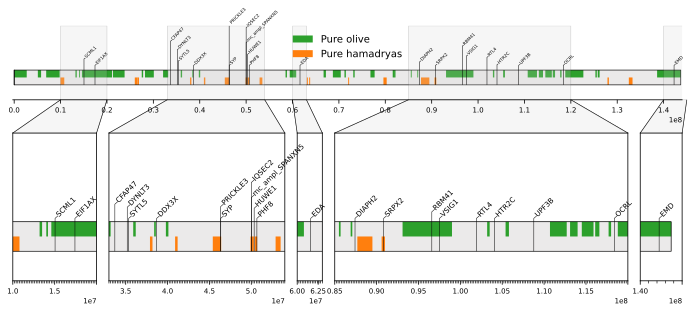

In [36]:
#| label: fig-gog-pure-reions-cDEG


g = gplt.ChromIdeogram('chrX', assembly='papAnu4', 
                    font_size=3,
                       zoom_height_ratio=2, 
                       zoom_font_size=5, 
                       zoom_effect_alpha=0.2,
#                       ylim=(0, 10),
                          zooms=[
        (10_000_000, 20_000_000),
        (33_000_000, 54_000_000),
        (60_000_000, 63_000_000),
        (85_000_000, 120_000_000),
        (140_000_000, 145_000_000),
    ]
                      )

g.draw_chromosomes(base=2)
g.add_segments([(t.chrom, t.start, t.end) for t in olive_pure_segments.itertuples()], 
               facecolor='tab:green', base=3, height=1, label='Pure olive', alpha=0.7)
g.add_segments([(t.chrom, t.start, t.end) for t in hama_pure_segments.itertuples()], 
               facecolor='tab:orange', base=2, height=1, label='Pure hamadryas', alpha=0.7)


# ax.fill_between(x, y, 0, where=(y > 0), ec='none', fc='tab:red')
# ax.fill_between(x, y, 0, where=(y < 0), ec='none', fc='tab:blue')

# def color(name):
#     return 'black' if name in hum_nean_genes else 'black'

#gi.gene_coords(['DYNLT3', 'CFAP47'], assembly='papAnu4')

coords = gi.gene_labels(sheet.get('cDEG'), assembly='papAnu4')

# coords = []
# coords.extend(
#     [(tup[0], (tup[1]+tup[2])/2, name) for name, tup in gi.gene_coord(cDEG_genes, species='papio_anubis', assembly='papAnu4').items()]
# )

# #plot_df['y1'] = 1
# g.map_method(Axes.fill_between, data=plot_df, x='x', y='y', y2=1, where=(y > 0), ec='none', fc='tab:red', yaxis=(1, 2), label='A compartment')
# g.map_method(Axes.fill_between, data=plot_df, x='x', y='y', y2=1, where=(y <= 0), ec='none', fc='tab:blue', yaxis=(1, 2), label='B compartment')

#g.map_method(Axes.plot, data=plot_df, x='x', y='y', yaxis=(1, 2), label='A compartment')

# ax.fill_between(x, y, 0, where=(y > 0), ec='none', fc='tab:red')
# ax.fill_between(x, y, 0, where=(y < 0), ec='none', fc='tab:blue')

# g.add_horizon(plot_df, cut=0.1, palette='bluered_r')

# new_ax = g.add_axes(1, hspace=0.5)
# new_ax.fill_between(x, y, 0, where=(y > 0), ec='none', fc='tab:red')
# new_ax.fill_between(x, y, 0, where=(y < 0), ec='none', fc='tab:blue')

#coords = [(tup[0], (tup[1]+tup[2])/2, name) for name, tup in gi.gene_coord(cDEG_genes, species='papio_anubis', assembly='papAnu4').items()]
#g.add_labels(coords)
g.add_labels(coords, base=g.ideogram_base, min_height=g.ideogram_height*1.5, 
             zoom_base=g.ideogram_base, zoom_min_height=g.ideogram_height*1.2, color='black')
g.add_legend()